<a href="https://colab.research.google.com/github/sogangori/choongang20/blob/master/SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미션 :
- 데이터획득: .mat 에서 x, y 를 가져옵니다
- 전처리 :  x, y 를 학습할 수 있게 만듭니다
   - x : (h,w,c,m) > (m,h,w,c) 로 수정
   - y : (m,1) > (m) 로 수정
     - y 의 라벨을 확인하세요. 숫자 0 의 라벨이 '10'입니다. 이것을 0으로 수정하세요
- 모델 생성: CNN, RNN, CRNN 등의 모델을 만듭니다
- 학습 및 평가: 데이터를 학습시키고 성능을 측정합니다

In [18]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import files

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
# 파일 업로드 방식
uploaded = files.upload()

In [0]:
# 구글 드라이브에 파일을 업로드해두고 읽는 방식
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [0]:
mat = loadmat('test_32x32.mat')
mat.keys()

In [24]:
# 데이터 획득
x = mat['X']
y = mat['y']
x.shape, y.shape

((32, 32, 3, 26032), (26032, 1))

In [25]:
# 전처리
x = np.transpose(x, [3,0,1,2])/255
y = y[:, 0]
x.shape, y.shape, np.max(x)

((26032, 32, 32, 3), (26032,), 1.0)

In [26]:
# y 에서 10값을 0으로 바꾸기
y = np.where(y > 9, 0, y)
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [0]:
m = len(y)//2
x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]

In [0]:
def attach_3_image(x, y):
  #영상을 좌우로 붙여서 3자리수 데이터를 만듭니다 x (m,h,w,c), y (m) 
  m = len(y)
  m = m - m % 3 
  x, y = x[:m], y[:m]# 3의 배수의 데이터수 사용    
  x_attach = np.concatenate((x[::3], x[1::3], x[2::3]), axis=2)
  y_attach = np.reshape(y, [-1, 3])
  return x_attach, y_attach

In [98]:
x3_train, y3_train = attach_3_image(x_train, y_train)
x3_test, y3_test = attach_3_image(x_test, y_test)
x3_train.shape, y3_train.shape, x3_test.shape, y3_test.shape

((4338, 32, 96, 3), (4338, 3), (4338, 32, 96, 3), (4338, 3))

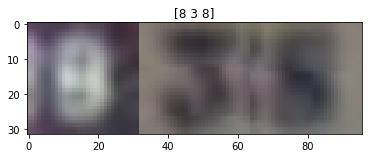

In [95]:
i = 10
plt.title(str(y3_train[i]))
plt.imshow(x3_train[i])

In [0]:
class MyModel(keras.Model): # github.com/sogangori/choongang20/ 
  def __init__(self):    
    super(MyModel, self).__init__()
    self.k = 10
    self.opt = tf.optimizers.RMSprop(learning_rate=0.01)#Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv2 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv3 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(units=self.k)
  
  def call(self, x):
    x = tf.cast(x, tf.float32)
    net = self.conv0(x)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.conv2(net)
    net = self.pool1(net)
    net = self.conv3(net)
    net = self.pool1(net)
    net = self.flatten(net)    
    h = self.dense(net)
    h = tf.nn.softmax(h, axis=1)
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-6, 1 - 1e-6) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    #cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    cross_entropy = - (y * tf.math.log(h)) #좌측항만 사용해도 학습 가능
    loss = tf.reduce_mean(cross_entropy)
    w_mean = [(tf.reduce_mean(tf.square(w))) for w in model.trainable_variables]
    loss_regularization = tf.reduce_mean(w_mean)#weight 가 커지지 않도록 제한하는 로스
    return loss + 0.0001 * loss_regularization

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast

  def fit(self, x, y, epoch=1):
    y_hot = tf.one_hot(y, depth=self.k, axis=-1)
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)         
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      #경사가 너무 크면 nan 이 될 수 있으므로 gradient cliping (최소,최대값 제한) 을 합니다
      grads = [(tf.clip_by_value(grad, -8.0, 8.0)) for grad in grads]      
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)

      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f'%(i, epoch, loss, self.acc))
model = MyModel()

In [129]:
model.fit(x_train[:100], y_train[:100], epoch=100)

0/100 loss:0.228 acc:0.180
10/100 loss:0.222 acc:0.270
20/100 loss:0.214 acc:0.270
30/100 loss:0.241 acc:0.270
40/100 loss:0.192 acc:0.300
50/100 loss:0.188 acc:0.370
60/100 loss:0.125 acc:0.600
70/100 loss:0.153 acc:0.440
80/100 loss:0.074 acc:0.740
90/100 loss:0.113 acc:0.630


In [0]:
#시퀀셜 모델
model = keras.Sequential()
model.add(keras.layers.Input((32,32,3)))
model.add(keras.layers.Conv2D(3, [3,3], padding='same'))
model.add(keras.layers.MaxPool2D((2,2), padding='same'))
model.add(keras.layers.Conv2D(6, [3,3], padding='same'))
model.add(keras.layers.MaxPool2D((2,2), padding='same'))
model.add(keras.layers.Flatten())# 1D 로 모양 바꾸기
model.add(keras.layers.Dense(10, activation=keras.layers.Softmax())) # 클래스가 10개이므로 
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
model.fit(x, y, epochs=10)

Train on 26032 samples
Epoch 1/10
26032/26032 [==============================] - 18s 696us/sample - loss: 2.0476 - accuracy: 0.2855
Epoch 2/10
26032/26032 [==============================] - 18s 698us/sample - loss: 1.4598 - accuracy: 0.5371
Epoch 3/10
26032/26032 [==============================] - 18s 683us/sample - loss: 1.1136 - accuracy: 0.6619
Epoch 4/10
26032/26032 [==============================] - 18s 685us/sample - loss: 0.9632 - accuracy: 0.7123
Epoch 5/10
26032/26032 [==============================] - 18s 691us/sample - loss: 0.8828 - accuracy: 0.7422
Epoch 6/10
26032/26032 [==============================] - 18s 689us/sample - loss: 0.8357 - accuracy: 0.7571
Epoch 7/10
26032/26032 [==============================] - 18s 688us/sample - loss: 0.8009 - accuracy: 0.7681
Epoch 8/10
24800/26032 [===========================>..] - ETA: 0s - loss: 0.7731 - accuracy: 0.7797

KeyboardInterrupt: ignored

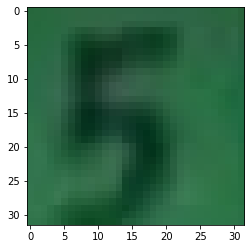

In [16]:
#모델 생성
epoch = 100
batch_m = 1000 # 메모리가 부족한 경우 데이터를 배치단위로 나눠서 학습시킵니다 
for i in range(epoch):
  iteration = np.ceil(len(y)/batch_m)
  for j in range(iteration):
    start = j * batch_m
    end = (j + 1) * batch_m
    x_batch = x[start:end]
    y_batch = y[start:end]
